In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from numpy.random import rand
import numpy as np
from qutip import *
import matplotlib.pyplot as plt


# Importation des modules
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Definition des parametres du systeme
N = 7  # Nombre de spins

Omega = 1  # Champ magnetique externe
gamma = 2  # Taux de decoherence
# Definition des operateurs de Paule
sx = sigmax()
sy = sigmay()
sz = sigmaz()

# Definition des operateurs de spins pour chaque site
sx_list = [tensor(sx, qeye(2**(N-1)))]*N
sy_list = [tensor(sy, qeye(2**(N-1)))]*N
sz_list = [tensor(sz, qeye(2**(N-1)))]*N

# Definition des projecteurs sur le spin-up pour chaque spin
n = [0.5*(tensor(qeye(2), qeye(2**(N-1))) + tensor(sz, qeye(2**(N-1))))]*N

# Definition du Hamiltonien
def H_obc(omega, V, alpha):
    # Hmiltonien du champ transversale
    H_0 = omega*sum(sx_list)

    # Hamiltonien d'interaction
    H_int = 0
    for i in range(N):
        for j in range(N):
            if i < j:
                H_int += (1/abs((i-j)**alpha)*n[i]*n[j])
    H_int = V*H_int
    H = H_0 + H_int
    return(H)
#print(H_obc(omega=1, V=0.3, alpha=10))

# Etat initial du systeme
a = np.random.uniform(0.01,0.7)
hro0_S = Qobj([[1-a,0],[0,a]])
# print(hro0_S)
hro0 = tensor(hro0_S, qeye(2**(N-1)))
print('Etat initial:',hro0_S)

hro0 = tensor(Qobj([[0.52066722,0], [0, 0.59590664]]), qeye(2**(N-1)))

# Liste des operateurs de Lindblad
L = []
for i in range(N):
    L.append(np.sqrt(gamma)*(sx_list[i]))

# Liste des temps
tlist = np.linspace(0.0, 1.0, 100)



alpha_list = np.arange(0, 12, 2)
V_list = np.arange(0, 2.2, 0.1)
omega = 1

mae_list = []
mse_list = []
for alpha in alpha_list:
    for V in V_list:
        # Evaluation des valeurs a travert la fonction mesolve
        H = H_obc(omega, V, alpha)
        result = mesolve(H, hro0, tlist, L, [sx_list[5], sy_list[5], sz_list[5]],args=None, options=None, progress_bar=None, _safe_mode=True)

        # Valeurs moyennes des operateurs de spins
        msx = result.expect[0]
        msy = result.expect[1]
        msz = result.expect[2]

        # Generation des donnees d'apprentissage du MLP

        # Donnees d'entrees
        tlistx = np.linspace(0, 1, 100)
        resultx = mesolve(H, hro0, tlistx, L, [sx_list[5], sy_list[5], sz_list[5]], args=None, options=None, progress_bar=None, _safe_mode=True)
        X0 = resultx.expect[0]
        X1 = resultx.expect[1] 
        X2 = resultx.expect[2]
        # Donnees de sortie
        tlisty = np.linspace(0+0.1, 1, 100)
        resulty = mesolve(H, hro0, tlisty, L, [sx_list[5], sy_list[5], sz_list[5]], args=None, options=None, progress_bar=None, _safe_mode=True)
        Y0 = resulty.expect[0]
        Y1 = resulty.expect[1]
        Y2 = resulty.expect[2]

        X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
        Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relles

        #Division de l'ensemble des donnees en donnees de formation et en donnees de test
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)


        # Architechture neuronale du perceptron multicouche
        model = MLPRegressor(hidden_layer_sizes =(200, 200, 200), activation='relu', solver='adam', alpha = 0.001)

        #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
        model.fit(X_train, Y_train)

        #Evaluation de la performence du modele avec l'ensemble des donnees de test
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        mse_list.append(mse)
        mae_list.append(mae)
print(mae_list)
        


Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.97800029 0.        ]
 [0.         0.02199971]]
[0.006715070030438744, 0.006409310440954399, 0.018826859471496166, 0.043760436935748256, 0.046328264345841905, 0.05159603952471056, 0.029984505715035505, 0.01828360966997497, 0.01716130198081543, 0.011581605476257868, 0.015949241237498767, 0.011561740509644786, 0.014486530099540356, 0.01152587007803162, 0.020601711986704227, 0.009110480299396435, 0.012785957147341131, 0.009047903860288222, 0.008554378008574772, 0.012503257498209167, 0.010187597940489145, 0.007982347292534143, 0.008821899719964285, 0.005542179568396319, 0.006502606929572892, 0.014216448832028206, 0.009289050212070625, 0.015761469024972486, 0.025230307320783112, 0.03572966244646716, 0.03530897648372982, 0.05191502978554409, 0.0393118759257633, 0.057546198070229884, 0.058886807998704, 0.037563949856763056, 0.04376006969565801, 0.027011827705340996, 0.039122998599851355,

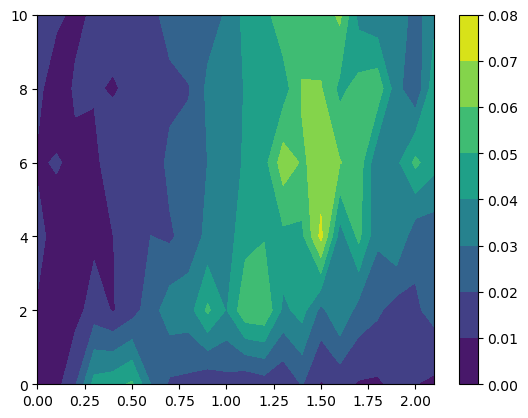

In [5]:
z = np.array(mae_list)
#print(mae_list)
X, Y = np.meshgrid(V_list, alpha_list)

Z = z.reshape(Y.shape)

fig = plt.figure()
ax1 = plt.contourf(X, Y, Z)
plt.colorbar(ax1)
#ax1.set_ylabel('Alpha')
#ax1.set_xlabel('V')
plt.show()

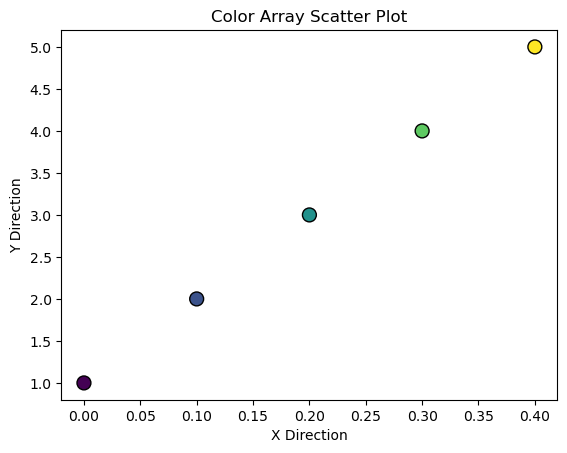

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data points
x_data = np.array([0, 0.1, 0.2, 0.3, 0.4])
y_data = np.array([1, 2, 3, 4, 5])

# Create a scatter plot
plt.scatter(x_data, y_data, c=y_data, cmap='viridis', s=100, edgecolors='k')

# Add labels and title
plt.xlabel('X Direction')
plt.ylabel('Y Direction')
plt.title('Color Array Scatter Plot')

# Show the plot
plt.show()


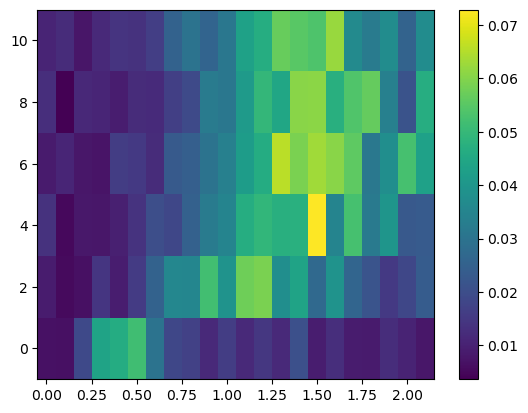

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2-D grid from the 1-D arrays
X, Y = np.meshgrid(V_list, alpha_list)

# Define a function to plot
Z = z.reshape(Y.shape)

# Create a pseudocolor plot with a non-regular rectangular grid
plt.pcolormesh(X, Y, Z)
plt.colorbar() # Add a color bar to show the scale

# Show the plot
plt.show()